In [1]:
import pandas as pd
import numpy as np
from plotly_dataframe import plot 
from metrics import metrics
import os
import shutil
from plotly_plt_predictions import plot_predictions
from tqdm import tqdm
from ipywidgets import widgets, interact
import matplotlib.pyplot as plt
from plot_map import choropleth
from IPython.display import clear_output, display
from pyramid.arima import auto_arima

# Forecasting - Food Consumption Score (FCS)

In [2]:
# Load the original data (smoothed data) of the second version of fcs indicator released by wfp.
df = pd.read_csv("../../../Data Sources/Food Consumption Score (FCS)/time-series/Yemen/wfp_fcs-v2-daily-interpolate.csv", header = [0, 1], index_col = 0)
df.index.name = "Datetime"
df.index = pd.to_datetime(df.index)
freq = "D"
df.index.freq = freq
df.columns.names = ["AdminStrata", "Indicator"]
df.head()

AdminStrata,Abyan,Aden,Al Bayda,Al Dhale'e,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amanat Al Asimah,Amran,...,Hadramaut,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'ada,Sana'a,Shabwah,Taizz
Indicator,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,...,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS,FCS
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-02,31.158690,16.619519,38.332669,29.194825,20.788151,22.085706,2.892308,16.815145,17.000398,20.446735,...,23.822825,28.361345,25.036668,31.762436,32.596233,54.121774,17.676022,26.917713,16.752289,26.563365
2018-07-03,32.675222,16.370603,43.292084,31.336940,20.692544,23.477196,2.913825,19.833443,17.208166,21.689014,...,23.699881,28.805448,27.102390,32.049499,33.333333,56.722689,17.134560,25.783476,18.257453,29.124005
2018-07-04,33.415597,15.089163,45.128205,33.135157,21.825051,24.864000,2.950408,19.614289,18.070801,25.611124,...,23.103187,30.993706,29.844066,33.106267,36.883683,56.306306,17.454545,25.436047,19.083081,29.427973
2018-07-05,33.531451,15.766521,43.959297,34.554309,21.481693,27.814992,2.247913,19.558566,19.021964,27.922484,...,21.596419,32.905902,29.025363,32.938828,36.897633,56.231003,17.846350,27.421759,20.349533,30.456026
2018-07-06,33.951856,16.870065,44.516521,33.878557,21.076712,28.688245,2.269780,17.608130,19.817567,28.712235,...,20.129084,32.598181,30.692766,33.837934,36.669568,57.324841,18.463057,26.547231,21.107524,31.012517


In [3]:
#plot(fcs, title = "FCS indicator", yaxis = "% of people with poor and borderline FCS", style = "lines")

In [4]:
# Define the desired length of the test set.
TEST = 30
# Define the metric to evaluate the model.
ERROR = "MSE"
# Set boolean parameter to perform an optional grid search.
GRID_SEARCH = True

In [5]:
# Define the training set and the test set.
train = df[:-TEST]  
test = df[-TEST:]

In [6]:
# Create workspace.
dir = "./output"
if not os.path.exists(dir):
    os.makedirs(dir)
else:
    shutil.rmtree(dir)           
    os.makedirs(dir)
    
os.makedirs(dir + "/images")
os.makedirs(dir + "/grid_search")

# Create a txt file where I annotate the above chosen parameters.
with open(dir + "/setting.txt", "w") as f:
    f.write("GRID SEARCH: %s \n" % GRID_SEARCH)
    f.write("TEST: %d \n" % TEST)
    f.write("ERROR: %s \n" % ERROR)

# Autoregressive Integrated Moving Average (ARIMA) model

The Autoregressive Integrated Moving Average (ARIMA) is a class of statistical models for analyzing and forecasting time-series data.

It combines both Autoregression (AR) with p order and Moving Average (MA) with q order models as well as a differencing pre-processing step of the sequence to make the sequence stationary, called integration (I) with d order. Autoregression expresses the correlation between observations, i.e. , how much the current values influences the next ones. The integration procedure indicates the number of differences required to guarantee the stationarity of the series. Lastly, the MA part comprises unknown factors that cannot be explained by the time series past values.

The user must specify a tuple of p, d, and q ARIMA parameters. We want to perform a grid search for finding the best setting of these parameters. The statsmodels ARIMA procedure internally uses numerical optimization procedures to find a set of coefficients for the model. These procedures can fail, which in turn can throw an exception. We must catch these exceptions and skip those configurations that cause a problem. 

# Forecasting

In [7]:
figures = dict()
df_prediction = dict()

In [13]:
def forecast(group):
    adminstrata = group.name
    # Reduce the group dataframe to simple serie.
    serie = group[adminstrata]["FCS"]

    # Prediction.
    model = auto_arima(serie, start_p = 1, start_q = 1, max_p = 366, max_q = 366, 
                       start_P = 0, seasonal = False, d = None, D = None, trace = False,
                       max_order = None, error_action = "ignore", suppress_warnings = True, 
                       stepwise = True)
    predicted = pd.Series(model.predict(TEST), index = test.index)
    
    # Define the entire original FCS time-series: train + test.
    original = pd.concat([serie, test[adminstrata]["FCS"]])
    # Plot of the prediction.
    figure = plot_predictions(original, predicted, title = adminstrata, plotly = False, 
                              save = True, dir_to_save = dir + "/images/")
    
    # Store into dictionary.
    figures[adminstrata] = figure
    df_prediction[adminstrata] = predicted
    
    error = metrics(test[adminstrata]["FCS"], predicted, ERROR).compute()
    
    return error

In [14]:
tqdm.pandas()
errors = train.groupby(level = 0, axis = 1).progress_apply(forecast)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:36<00:00,  1.73s/it]


In [15]:
errors.mean()

23.778865562238824

In [16]:
def plot_prediction(name):
    fig = figures[name]
    display(fig)

In [17]:
w = widgets.Dropdown(options = df.columns.get_level_values(0).unique(), description = df.columns.get_level_values(0).name, 
                     disabled = False)
p = interact(plot_prediction, name = w)

interactive(children=(Dropdown(description='AdminStrata', options=('Abyan', 'Aden', 'Al Bayda', "Al Dhale'e", …

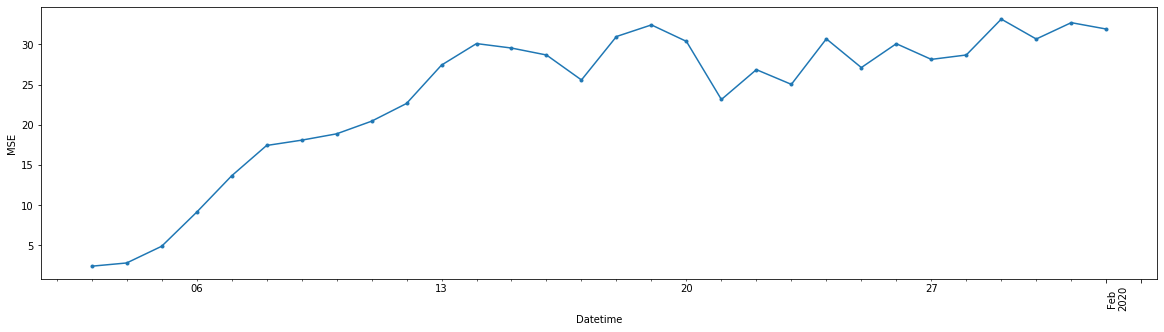

In [18]:
# Plot the mean error in function of the time.
def error_time(serie):
    date = serie.name
    pred_time = pd.DataFrame(df_prediction).transpose()[date]
    error = metrics(serie, pred_time, ERROR).compute()
    return error
    
prediction_time = test.transpose().apply(error_time)

# Show plot.
f = plt.figure(figsize = (20, 5))
prediction_time.plot(ax = f.gca(), style = ".-")
plt.ylabel(ERROR)
plt.xlabel("Datetime")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()

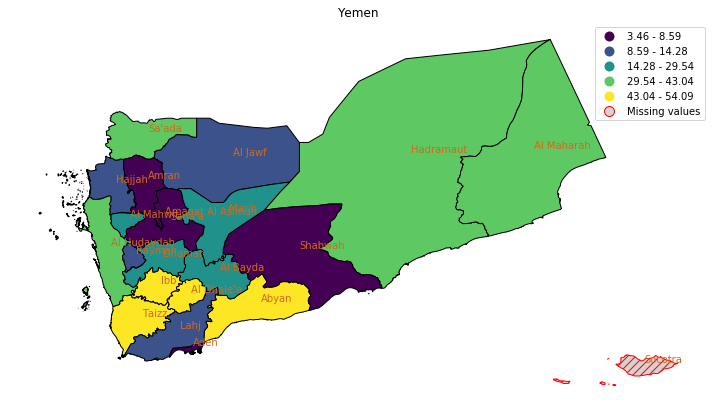

In [19]:
choropleth("Yemen", df.columns.get_level_values(0).unique(), errors, annotation = True, figsize = (15, 7))

In [20]:
# Save the results dataframe.
predictions = pd.DataFrame(df_prediction)
predictions.columns = pd.MultiIndex.from_product([predictions.columns, ["FCS"]])
predictions.columns.names = ["AdminStrata", "Indicator"]

In [21]:
test.to_csv(dir + "/test.csv")
predictions.to_csv(dir + "/ARIMA.csv")